# 

In [1]:
# Import public packages.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import ndimage as ndi 
from importlib import reload
import pickle
import czifile
from skimage.filters.thresholding import threshold_otsu
import flymovie as fm

# The order of loading matplotlib is important to avoid issues on my machine.
%matplotlib inline
import matplotlib as mpl
#%matplotlib notebook
#%matplotlib notebook

# Import my packages.
import sys
sys.path.append('/Users/michaelstadler/Bioinformatics/Projects/rpb1/bin')

from flymovie import viewer, save_pickle, load_pickle, box_spots, read_czi

## Functions

In [2]:
from flymovie.fitting import fitgaussian3d, gaussian3d
from flymovie import get_object_centroid, clamp

def fit_objects_from_mask(stack, mask, fitwindow_rad_xy=10, fitwindow_rad_z=2):  
    """Find the centroids of all connected objects in a binary mask, perform
    3D gaussian fitting on each object."""
    def get_fitwindow(data, peak, xy_rad, z_rad):
        """Retrieve section of image stack corresponding to given
        window around a point and the coordinate adjustments necessary
        to convert window coordinates to coordinates in the original image"""
        
        # Set the start points for windows and "adjust" them if they get 
        # to negative numbers.
        zmin = peak[0] - z_rad
        xmin = peak[1] - xy_rad
        ymin = peak[2] - xy_rad
        # Initialize adjustments to values that are correct if no edge problems 
        # are encountered.
        z_adj = -z_rad
        x_adj = -xy_rad
        y_adj = -xy_rad
        # Update mins and adjustments if windows start at negative coordinates.
        if (zmin < 0):
            zmin = 0
            z_adj = -peak[0]
        if (xmin < 0):
            xmin = 0
            x_adj = -peak[1]
        if (ymin < 0):
            ymin = 0
            y_adj = -peak[2]

        # Get end points, constained by max coordinate in data.
        zmax = min(data.shape[0] - 1, peak[0] + z_rad)
        xmax = min(data.shape[1] - 1, peak[1] + xy_rad)
        ymax = min(data.shape[2] - 1, peak[2] + xy_rad)

        return (data[zmin:(zmax+1), xmin:(xmax+1), ymin:(ymax+1)], z_adj, x_adj, y_adj)
    
    def get_centroids(labelmask):
        centroids = []
        for id_ in np.unique(labelmask):
            centroids.append(get_object_centroid(labelmask, id_))
        return centroids
    
    def fit_frame(substack, submask):
        labelmask = ndi.label(submask)[0]
        peaks = get_centroids(labelmask)
        count = 0
        
        # Fit 3D gaussian in window surrounding each local maximum.
        fitparams = np.ndarray((0,7))
        for peak in peaks:
            count += 1
            if ((count % 100) == 0):
                print(count, end=' ')
            fitwindow, z_adj, x_adj, y_adj = get_fitwindow(substack, peak, fitwindow_rad_xy, 
                fitwindow_rad_z)
            opt = fitgaussian3d(fitwindow)
            if opt.success:
                peak_fitparams = opt.x
                # Move center coordinates to match center of gaussian fit, ensure they're within image. 
                # If they're outside the image, coordinate is assigned as the edge of the image.
                peak_fitparams[0] = int(round(clamp((peak[0] + peak_fitparams[0] + z_adj), 0, substack.shape[-3]-1)))
                peak_fitparams[1] = int(round(clamp((peak[1] + peak_fitparams[1] + x_adj), 0, substack.shape[-2]-1)))
                peak_fitparams[2] = int(round(clamp((peak[2] + peak_fitparams[2] + y_adj), 0, substack.shape[-1]-1)))
                fitparams = np.vstack((fitparams, peak_fitparams))
            # If fit fails, add dummy entry for spot.
            else:
                fitparams = np.vstack((fitparams, np.array([z_adj,x_adj,y_adj,0,np.inf,np.inf,np.inf])))
        return fitparams
    
    fit_data = []
    for t in range(0, stack.shape[0]):
        print(t)
        fit_data.append(fit_frame(stack[t], mask[t]))
    
    return fit_data

In [3]:
def fg_bg(x, inner_ij=5, outter_ij=7, inner_z=1, outter_z=3, bg_subtract=True):
    """Perform foreground-background comparison for individual frames in an 4d
    array, where first dimension is spot ID. For each frame (spot ID), define an 
    inner box and a larger outter box, find the mean pixel value in the inner
    box and then in the positions that are in the outter box but not in inner box 
    ('background'), return the differences as a list."""
    # Get points for ij:
    midpoint = int(x.shape[-1] / 2)
    inner_rad_ij = int(inner_ij / 2)
    outter_rad_ij = int(outter_ij / 2)
    inner_start_ij = midpoint - inner_rad_ij
    inner_end_ij = midpoint + inner_rad_ij + 1
    outter_start_ij = midpoint - outter_rad_ij
    outter_end_ij = midpoint + outter_rad_ij + 1
    # Get points for z:
    midpoint_z = int(x.shape[-3] / 2)
    inner_rad_z = int(inner_z / 2)
    outter_rad_z = int(outter_z / 2)
    inner_start_z = midpoint_z - inner_rad_z
    inner_end_z = midpoint_z + inner_rad_z + 1
    outter_start_z = midpoint_z - outter_rad_z
    outter_end_z = midpoint_z + outter_rad_z + 1
    
    diffs = []
    for box in x:
        inner_box = box[inner_start_z:inner_end_z, inner_start_ij:inner_end_ij, inner_start_ij:inner_end_ij]
        if (bg_subtract):
            outter_box = box[outter_start_z:outter_end_z, outter_start_ij:outter_end_ij, outter_start_ij:outter_end_ij] 
            outter_mean = (np.sum(outter_box) - np.sum(inner_box)) / (outter_box.size - inner_box.size)
            inner_mean = np.mean(inner_box)
            bgsub_diff = inner_mean - outter_mean
            diffs.append(bgsub_diff)
        else:
            diffs.append(np.mean(inner_box))
    return diffs  

#-----------------------------------------------------------------------
def bundle_spots_byz(stack4d, stack5d, fits, len_ij=31, len_z=5):
    """Take a set of fitting data, make 4d spot movie structures for each
    Z slice, bundle these into a list where the index is the z slice number."""
    spots_byz = []
    for i in range(0, stack4d.shape[-3]-1):
        zslice_bool = fits[0][:,0] == i
        if (np.count_nonzero(zslice_bool) > 0):
            fits_zslice = [fits[0][zslice_bool]]
            spot_data = fm.connect_ms2_fits_focuscorrect(fits_zslice, [0], [0], np.zeros_like(stack4d))
            spots = fm.spot_movies(stack5d, spot_data, fill=0, len_ij=len_ij, len_z=len_z, view=False)
            spots = np.squeeze(spots, axis=1)
            spots_byz.append(spots)
        else:
            spots_byz.append(np.zeros((1,len_z, len_ij, len_ij)))
        
    return spots_byz

#-----------------------------------------------------------------------
def fg_bg_byz(spots_byz, inner_ij=5, outter_ij=9, inner_z=1, outter_z=1, bg_subtract=True, return_mean=True, min_spots_for_mean=4):
    """Wrapper: call fg_bg on stack for each z slice output by bundle_spots_byz, """
    y = []
    x = []
    n = len(spots_byz)
    for i in range(0, n):
        vals = fg_bg(spots_byz[i], inner_ij=inner_ij, outter_ij=outter_ij, inner_z=inner_z, 
                     outter_z=outter_z, bg_subtract=bg_subtract)
        vals = np.array(vals)
        low_cut, high_cut = np.percentile(vals, [10,90])
        vals_middle = vals[(vals >= low_cut) & (vals <= high_cut)]
        if (return_mean):
            if (len(vals) > min_spots_for_mean):
                y.append(np.mean(vals_middle))
            else:
                y.append(np.nan)
            x.append(i)
        else:
            y = y + list(vals_middle)
            x = x + ([i] * len(vals_middle))
    return x,y

#-----------------------------------------------------------------------
def make_plottable(datasets, surface, start, interval, bg_subtract=True, return_mean=True, min_spots_for_mean=4):
    """Build x and y vectors for plotting spot intensity values (via fg_bg) against 
    embryo depth."""
    x = []
    y = []
    for i in range(0, len(datasets)):
        x0, y0 = fg_bg_byz(datasets[i], bg_subtract=bg_subtract, return_mean=return_mean, min_spots_for_mean=min_spots_for_mean)
        y = y + y0
        x1 = (np.array(x0) * interval) + start[i] - surface[i]
        x = x + list(x1)
    return np.array(x),np.array(y)

#-----------------------------------------------------------------------
def jitter(x, max_=0.8):
    noise = 0.5 * np.random.randn(len(x))
    noise[noise > max_] = max_
    noise[noise < (-1 * max_)] = -1 * max_
    return x + noise

In [23]:
folder = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/standard_candles'

## Processing 120-mer data

In [ ]:
del stack, stack3d, stack4d, stack5d, fits, dog, fits_filtered, mask, spots_byz

In [ ]:
# Read file.
czi_filename = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/quantitation/20210331-120mers-3pct-em6-01.czi'
stack = read_czi(czi_filename, swapaxes=True)
viewer(stack)

In [ ]:
# Make 4d and 5d stacks.
stack4d = stack[0,:1,:]
#stack4d = np.expand_dims(stack, axis=0)
stack5d = np.expand_dims(stack4d, axis=0)

In [ ]:
# Perform DoG filtering.
channel=0
sigma_big = 4
sigma_small = 0

stack3d = stack4d[channel]
dog = fm.dog_filter(stack3d, [0,sigma_small,sigma_small],[0,sigma_big,sigma_big])

In [ ]:
# Set a threshold for defining putative spots.
t = 10000
viewer(dog, color='cividis', init_minval=t, init_maxval=t+1)

In [ ]:
# Make a binary mask from threshold.
mask = np.where(dog >= t, 1, 0)
mask = ndi.morphology.binary_opening(mask, np.ones((1,2,2)))
mask = np.expand_dims(mask, 0)
viewer(mask)

In [ ]:
# Perform 3D gaussian fitting on each object in the binary mask.
fits = fit_objects_from_mask(stack4d, mask, fitwindow_rad_z=1, fitwindow_rad_xy=3)
#imp.quickview_ms2(stack5d, fits, MAX=True, shadows=False, halfwidth_z=0)

In [ ]:
# Filter spots based on fit parameters, view results.
peakiness = 8
fits_filtered = fm.filter_ms2fits(fits, peakiness, stack)
fm.quickview_ms2(stack5d, fits_filtered, MAX=False, shadows=False, halfwidth_z=0)

In [ ]:
# Get spot windows, organize by z slice.
spots_byz = bundle_spots_byz(stack4d, stack5d, fits_filtered)

In [ ]:
# Save results.
save_pickle(spots_byz.copy(), os.path.join(folder, '20210331_spots_byz_6_01.pkl'))

#spots_byz_331_6_02 = spots_byz.copy()

## Processing Rpb1 minor foci

In [ ]:
del stack, stack3d, stack4d, stack5d, fits, dog, fits_filtered, newfits, mask, spots_byz

In [ ]:
# Read file.
czi_filename = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/quantitation/20210331-rpbGFP-sisAMS2-488-3pct-em1-08-actuallyem2.czi'
stack = read_czi(czi_filename, swapaxes=True)
viewer(stack)

In [ ]:
# Make 4d and 5d stacks.
stack4d = stack[0,:1,:]
#stack4d = np.expand_dims(stack, axis=0)
stack5d = np.expand_dims(stack4d, axis=0)

In [ ]:
# Perform DoG filtering.
channel=0
sigma_big = 4
sigma_small = 0

stack3d = stack4d[channel]
dog = fm.dog_filter(stack3d, [0,sigma_small,sigma_small],[0,sigma_big,sigma_big])

In [ ]:
# Set a threshold for defining putative spots.
t = 8000
viewer(dog, color='cividis', init_minval=t, init_maxval=t+1)

In [ ]:
# Make a binary mask from threshold.
mask = np.where(dog >= t, 1, 0)
mask = ndi.morphology.binary_opening(mask, np.ones((1,2,2)))
mask = np.expand_dims(mask, 0)
viewer(mask.max(axis=1))

In [ ]:
# Perform 3D gaussian fitting on each object in the binary mask.
fits = fit_objects_from_mask(stack4d, mask, fitwindow_rad_z=1, fitwindow_rad_xy=3)
#imp.quickview_ms2(stack5d, fits, MAX=True, shadows=False, halfwidth_z=0)

In [ ]:
# Filter spots based on fit parameters, view results.
peakiness = 8.5
fits_filtered = fm.filter_ms2fits(fits, peakiness, stack)
fm.quickview_ms2(stack5d, fits_filtered, MAX=False, shadows=False, halfwidth_z=0)

In [ ]:
# Get rid of HLB (need to improve this).
spot_data = fm.connect_ms2_fits_focuscorrect(fits_filtered, [0], [0], np.zeros_like(stack4d))
spots = fm.spot_movies(stack5d, spot_data, fill=0, len_ij=31, len_z=7, view=False)
spots = np.squeeze(spots)[1:] # Remove the blank first frame.
vals = np.array(fg_bg(spots, inner_ij=11, inner_z=3, bg_subtract=False))

In [ ]:
plt.hist(vals, bins=20);

In [ ]:
# Find a threshold that excludes HLB.
t = 20000
newfits = fits_filtered.copy()
newfits[0] = newfits[0][vals <= t]
fm.quickview_ms2(stack5d, newfits, MAX=False, shadows=False, halfwidth_z=0)

In [ ]:
spots_byz = bundle_spots_byz(stack4d, stack5d, newfits)

In [ ]:
save_pickle(spots_byz.copy(), os.path.join(folder, '20210331-rpbGFP-sisAMS2-488-3pct-em2-08.pkl'))

#spots_byz_rpb1_2_08 = spots_byz.copy()

## Processing MS2

In [ ]:
del stack, stack3d, stack4d, stack5d, fits, dog, fits_filtered, newfits, mask, spots_byz, nucmask

In [ ]:
# Read file.
#4-01, 6-01, 19-01
folder = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/quantitation/'
czi_filename = '20210331-MCPGFP-hbMS2-488-3pct-em1-03.czi'
stack = read_czi(os.path.join(folder, czi_filename), swapaxes=True)
stack = stack[:,:,8:]
viewer(stack, 8)

In [ ]:
# Make 4d and 5d stacks.
stack4d = stack[0,:1,:]
#stack4d = np.expand_dims(stack, axis=0)
stack5d = np.expand_dims(stack4d, axis=0)

In [ ]:
# Make quick nuclear mask.
his_channel=1
mcp_channel=0
hisstack = stack[his_channel, 0].copy()
hisstack = ndi.gaussian_filter(hisstack, sigma=3)
t = threshold_otsu(hisstack)
mask = np.where(hisstack > t, 1, 0)
mask = ndi.morphology.binary_dilation(mask, np.ones((1,5,5)))
mask = ndi.morphology.binary_opening(mask, np.ones((1,2,2)))
labelmask,_ = ndi.label(mask)
labelmask = fm.labelmask_filter_objsize(labelmask, 50000, 300000)
nucmask = np.where(labelmask > 0, 1, 0)
viewer(nucmask)

In [ ]:
# Perform DoG filtering.
channel=0
sigma_big = 4
sigma_small = 0

stack3d = stack4d[channel]
dog = fm.dog_filter(stack3d, [0,sigma_small,sigma_small],[0,sigma_big,sigma_big])
dog = np.where(nucmask, dog, 0)

In [ ]:
# Set a threshold for defining putative spots.
t = 10000
viewer(dog, color='cividis', init_minval=t, init_maxval=t+1)

In [ ]:
# Make a binary mask from threshold.
mask = np.where(dog >= t, 1, 0)
mask = ndi.morphology.binary_opening(mask, np.ones((1,2,2)))
mask = np.expand_dims(mask, 0)
viewer(mask.max(axis=1))

In [ ]:
# Perform 3D gaussian fitting on each object in the binary mask.
fits = fit_objects_from_mask(stack4d, mask, fitwindow_rad_z=1, fitwindow_rad_xy=3)
#imp.quickview_ms2(stack5d, fits, MAX=True, shadows=False, halfwidth_z=0)

In [ ]:
# Filter spots based on fit parameters, view results.
peakiness = 8
fits_filtered = fm.filter_ms2fits(fits, peakiness, stack)
fm.quickview_ms2(stack5d, fits_filtered, MAX=False, shadows=False, halfwidth_z=0)

In [ ]:
# Get rid of transcription sites.
spot_data = fm.connect_ms2_fits_focuscorrect(fits_filtered, [0], [0], np.zeros_like(stack4d))
spots = fm.spot_movies(stack5d, spot_data, fill=0, len_ij=31, len_z=7, view=False)
spots = np.squeeze(spots)[1:]
vals = np.array(fg_bg(spots, inner_ij=11, inner_z=3, bg_subtract=False))
plt.hist(vals, bins=20);

In [ ]:
# Find a threshold that excludes HLB.
t = 25000
newfits = fits_filtered.copy()
newfits[0] = newfits[0][vals <= t]
fm.quickview_ms2(stack5d, newfits, MAX=False, shadows=False, halfwidth_z=0)

In [ ]:
spots_byz = bundle_spots_byz(stack4d, stack5d, newfits)

In [ ]:
save_pickle(spots_byz.copy(), os.path.join(folder, '20210331-MCPGFP-hbMS2-488-3pct-em1-03.pkl'))

#spots_byz_ms2_1_03 = spots_byz.copy()

## After processing

I run the above function on each dataset and also generate a matching vector with teh embryo depth of each slice, based on the recorded positions. These vectors are concatenated for all datasets.

In [17]:
# Load 120-mer datasets
spots_byz_331_2_02 = load_pickle(os.path.join(folder, '20210331_spots_byz_2_02.pkl'))
spots_byz_331_4_01 = load_pickle(os.path.join(folder, '20210331_spots_byz_4_01.pkl'))
spots_byz_331_4_02 = load_pickle(os.path.join(folder, '20210331_spots_byz_4_02.pkl'))
spots_byz_331_5_01 = load_pickle(os.path.join(folder, '20210331_spots_byz_5_01.pkl'))
spots_byz_331_5_02 = load_pickle(os.path.join(folder, '20210331_spots_byz_5_02.pkl'))
spots_byz_331_6_01 = load_pickle(os.path.join(folder, '20210331_spots_byz_6_01.pkl'))
spots_byz_331_6_02 = load_pickle(os.path.join(folder, '20210331_spots_byz_6_02.pkl'))




In [5]:
datasets = [spots_byz_331_4_01, spots_byz_331_4_02, spots_byz_331_2_02, spots_byz_331_5_01, spots_byz_331_5_02, spots_byz_331_6_01, spots_byz_331_6_02]
surface = [1565.78, 1564.08, 1615.68, 1564.51, 1564.33, 1568.97, 1567.8]
start = [1573.99, 1569.91, 1620.8, 1573.48, 1568.38, 1571.79, 1574.71]

interval = float(0.240)

x_120,y_120 = make_plottable(datasets, surface, start, interval, return_mean=False)
x_120_means,y_120_means = make_plottable(datasets, surface, start, interval, return_mean=True, min_spots_for_mean=10)

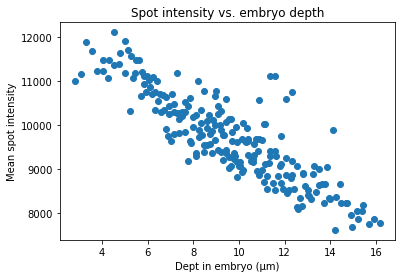

In [6]:
# Plotting all Rpb1 spots.
plt.scatter(x_120_means, y_120_means);
#plt.scatter(x_m_means, y_m_means, color='green');
#plt.scatter(x_r,y_r, alpha=0.15);
#plt.ylim((0,20000))
plt.xlabel('Dept in embryo (µm)')
plt.ylabel('Mean spot intensity')
plt.title('Spot intensity vs. embryo depth');

In [21]:
# Load rpb1 datasets
spots_byz_rpb1_4_02 = load_pickle(os.path.join(folder, '20210331-rpbGFP-sisAMS2-488-3pct-em4-02.pkl'))
spots_byz_rpb1_1_07 = load_pickle(os.path.join(folder, '20210331-rpbGFP-sisAMS2-488-3pct-em1-07.pkl'))
spots_byz_rpb1_2_08 = load_pickle(os.path.join(folder, '20210331-rpbGFP-sisAMS2-488-3pct-em2-08.pkl'))


In [8]:

# rpb1 datasets
datasets = [spots_byz_rpb1_4_02, spots_byz_rpb1_1_07, spots_byz_rpb1_2_08]
#datasets = [spots_byz_rpb1_2_08]
surface = [1292.75, 1301.6, 1300.97]
start = [1296.98, 1305.7, 1305.12]
interval = float(0.240)

x_r,y_r = make_plottable(datasets, surface, start, interval, return_mean=False)
x_r_means,y_r_means = make_plottable(datasets, surface, start, interval, return_mean=True, min_spots_for_mean=10)

In [22]:
# Load ms2 datasets
spots_byz_ms2_4_01 = load_pickle(os.path.join(folder, '20210331-MCPGFP-hbMS2-488-3pct-em4-01.pkl'))
spots_byz_ms2_6_01 = load_pickle(os.path.join(folder, '20210331-MCPGFP-hbMS2-488-3pct-em6-01.pkl'))
spots_byz_ms2_19_02 = load_pickle(os.path.join(folder, '20210331-MCPGFP-hbMS2-488-3pct-em19-02.pkl'))
spots_byz_ms2_15_01 = load_pickle(os.path.join(folder, '20210331-MCPGFP-hbMS2-488-3pct-em15-01.pkl'))
spots_byz_ms2_1_03 = load_pickle(os.path.join(folder, '20210331-MCPGFP-hbMS2-488-3pct-em1-03.pkl'))


In [10]:
# MS2 datasets
datasets = [spots_byz_ms2_4_01, spots_byz_ms2_6_01, spots_byz_ms2_19_02, spots_byz_ms2_15_01, spots_byz_ms2_1_03]
interval = float(0.240)
surface = [1432.66, 1419.6, 1373.14, 1331.35, 1428.40]
# 6-01 starts on slice 6
start = [1434.2, 1420.53 + (6 * interval), 1376.15, 1335.25, 1432.84 + (8 * interval)]

x_m,y_m = make_plottable(datasets, surface, start, interval, return_mean=False, min_spots_for_mean=5)
x_m_means,y_m_means = make_plottable(datasets, surface, start, interval, return_mean=True, min_spots_for_mean=5)

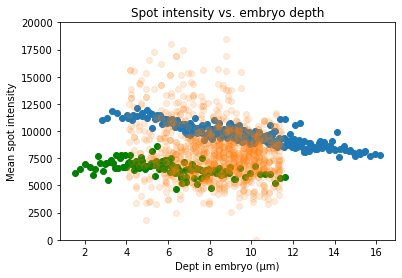

In [11]:
# Plotting all Rpb1 spots.
plt.scatter(x_120_means, y_120_means);
plt.scatter(x_m_means, y_m_means, color='green');
plt.scatter(x_r,y_r, alpha=0.15);
plt.ylim((0,20000))
plt.xlabel('Dept in embryo (µm)')
plt.ylabel('Mean spot intensity')
plt.title('Spot intensity vs. embryo depth');

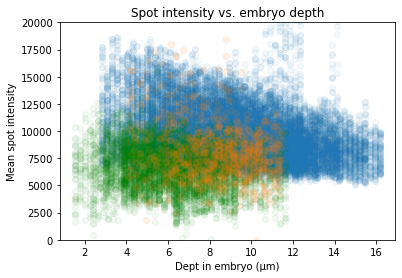

In [12]:
# Plotting all spots.
alpha=0.05
alpha_rpb=0.10
plt.scatter(x_120, y_120, alpha=alpha);
plt.scatter(x_m, y_m, color='green', alpha=alpha);
plt.scatter(x_r,y_r, alpha=alpha_rpb);
plt.ylim((0,20000))
plt.xlabel('Dept in embryo (µm)')
plt.ylabel('Mean spot intensity')
plt.title('Spot intensity vs. embryo depth');

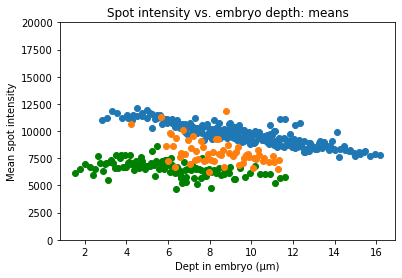

In [13]:
# Plotting Rpb1 slice means.
plt.scatter(x_120_means, y_120_means);
plt.scatter(x_m_means, y_m_means, color='green');
plt.scatter(x_r_means,y_r_means, alpha=1);
plt.ylim((0,20000))
plt.xlabel('Dept in embryo (µm)')
plt.ylabel('Mean spot intensity')
plt.title('Spot intensity vs. embryo depth: means');